# 使用PaddleX调用Resnet18根据数据集[年龄、性别和种族（人脸数据）](https://aistudio.baidu.com/aistudio/datasetdetail/106996)进行性别分类
## 背景
人脸是人类生活中暴露程度较高的部位，并且人脸能够较为明显地反馈出人的年龄，性别信息。对人脸信息进行识别，在特定场景下对人脸信息进行识别有助于提高生活的便捷程度，促进社会和谐，降低恶性事件的发生概率。如在厕所入口处进行人脸识别，可以在异性进入厕所时进行告警，从而避免女厕所的偷拍行为的出现、避免走错厕所的尴尬情形。

## 数据集介绍
[年龄、性别和种族（人脸数据）](https://aistudio.baidu.com/aistudio/datasetdetail/106996)包含了三个种族，两个性别，年龄从0到99分布的23705个人脸样本。每个人脸样本都通过一组数组进行存储，并且可以转化为48×48的灰度图像。


部分图片示例

| 0| 9999 | 11007|23033 |
| -------- | -------- | -------- |-------- |
| ![](https://ai-studio-static-online.cdn.bcebos.com/a23613fc17ac427aaf18145025641eeb279b2ac62dfc44e09f82d34c1c4549b7)     | ![](https://ai-studio-static-online.cdn.bcebos.com/694d7ec974f149c49026926160e92a5755b8d44491e84791820a226388b30dfc)     | ![](https://ai-studio-static-online.cdn.bcebos.com/b9885646d8d140fb98ebe80acfbb1dda5816d4c946784278b35f714ee7712364)     |![](https://ai-studio-static-online.cdn.bcebos.com/582d89735d8646c8b2f5e03cd088172ef5e358e453a640378f80178b96059ac7)   |








## 方案介绍

首先将数组转化为图相，调用PaddleX中的Resnet18进行性别分类。

# 代码

## 数据预处理

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import random

In [2]:
# 生成图像和对应标签
df=pd.read_csv('data/data106996/age_gender.csv')

! rm -r -f img
! mkdir img

def pixels2image(pixels): 
    return np.array(pixels.split()).astype(np.float).reshape(48, 48)

with open('gender_label.txt','w') as f:
    for i in range(len(df)):
        pixels=df['pixels'][i]
        img = pixels2image(pixels)
        img=Image.fromarray(img)
        img.convert('L').save('img/'+str(i)+'.jpg')
        f.write('img/'+str(i)+'.jpg\t'+str(df['gender'][i])+'\n')

with open('gender_name.txt','w') as f:
    f.write('男\n女')

with open('gender_label.txt','r') as f:
    lines=f.readlines()
    random.shuffle(lines)
    train_list=lines[:int(len(lines)*0.8)]
    eval_list=lines[int(len(lines)*0.8):]

with open('train_label.txt','w') as f:
    for item in train_list:
        f.write(item)

with open('eval_label.txt','w') as f:
    for item in eval_list:
        f.write(item)

## 使用PaddleX进行分类任务训练

In [ ]:
# 安装paddlex
!pip install paddlex

In [ ]:
# 导入包
import os
import random
import numpy as np
from random import shuffle
import cv2
import paddle
from PIL import Image
import shutil
import re
from paddle.vision.transforms import functional as F
import os.path
from PIL import Image
import paddlex as pdx
import sys
import pandas as pd

In [11]:
train_transforms = pdx.transforms.Compose([
        pdx.transforms.RandomHorizontalFlip(), 
        pdx.transforms.Normalize()])
        
eval_transforms = pdx.transforms.Compose([
        pdx.transforms.Resize([48,48]),
        pdx.transforms.Normalize()
    ])

train_dataset = pdx.datasets.ImageNet(
        data_dir='/home/aistudio',
        file_list='train_label.txt',
        label_list='gender_name.txt',
        transforms=train_transforms,
        shuffle=True)

eval_dataset = pdx.datasets.ImageNet(
        data_dir='/home/aistudio',
        file_list='eval_label.txt',
        label_list='gender_name.txt',
        transforms=eval_transforms)

2022-02-18 21:57:30 [INFO]	Starting to read file list from dataset...
2022-02-18 21:57:30 [INFO]	18964 samples in file train_label.txt
2022-02-18 21:57:30 [INFO]	Starting to read file list from dataset...
2022-02-18 21:57:30 [INFO]	4741 samples in file eval_label.txt


In [12]:
# 模型生成
num_classes = len(train_dataset.labels)
model = pdx.cls.ResNet18(num_classes=num_classes)
# model = pdx.load_model('paddlex/restnet200_vd/0.94167')
num_epochs=50

## 训练

In [ ]:
model.train(num_epochs=num_epochs,
                train_dataset=train_dataset,
                train_batch_size=1600,
                eval_dataset=eval_dataset,
                lr_decay_epochs=[int(num_epochs*0.4), int(num_epochs*0.7), int(num_epochs*0.9)],
                save_interval_epochs=int(num_epochs/5),
                learning_rate=0.00025,
                save_dir='cls/model',
                use_vdl=False)

## 测试模型效果

In [15]:
# 预测
num_classes = len(train_dataset.labels)
model = pdx.load_model('cls/model/best_model')

2022-02-18 22:01:15 [INFO]	Model[ResNet18] loaded.


In [27]:
T_count=0
F_count=0
with open('eval_label.txt','r') as f:
    for line in f.readlines():
        img_dir = line.split('\t')[0]
        label = int(line.split('\t')[1][0])
        pre = model.predict(img_dir)[0]['category_id']
        if pre==label:
            T_count+=1
        else:
            F_count+=1
print(f'acc is {T_count/(T_count+F_count)}')

acc is 0.757646066230753


## 可视化

2022-02-18 22:11:55 [INFO]	Model[ResNet18] loaded.
{'category_id': 0, 'category': '男', 'score': 0.9179523}


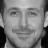

In [32]:
num_classes = len(train_dataset.labels)
model = pdx.load_model('cls/model/best_model')
print(model.predict('img/11046.jpg')[0])
from PIL import Image 
img = Image.open('img/11046.jpg')
img

# 总结
本项目使用PaddleX极简的构造了一个人脸分类模型，最终的分类结果精度仅有75%可能是因为包含了大量的幼年（婴儿）人脸，从而难以辨别，对学习器学习带来了一定的压力。可以考虑在做分类时将这部分样本剔除。

# 个人介绍

> 作者：笠雨聆月

> 兴趣：目前从最容易上手的cv进行学习，也在尝试nlp，gan等等，各种方向来者不拒

> 个人主页：https://aistudio.baidu.com/aistudio/personalcenter/thirdview/608082

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 